In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
from cpymad.madx import Madx

import sixtracklib as pyst

In [3]:
import h5py

In [4]:
from scipy.constants import e, m_p, c, epsilon_0

In [5]:
import sys, os
sys.path = ["/home/oeftiger/gsi/git/python3/PyHEADTAIL/", 
            "/home/oeftiger/gsi/git"] + sys.path

import pickle

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [7]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

from pycuda.driver import memcpy_dtod_async

In [8]:
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.general import pmath as pm
from PyHEADTAIL.particles.generators import (
    generate_Gaussian6DTwiss, cut_distribution, make_is_accepted_within_n_sigma)
from PyHEADTAIL.particles import generators

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.pypic_factory import create_3dmesh_from_beam, create_mesh
from PyHEADTAIL.spacecharge.pypic_spacecharge import (
    SpaceChargePIC, SpaceChargePIC_Adaptive25D)

from PyHEADTAIL.monitors.monitors import BunchMonitor, ParticleMonitor

from PyHEADTAIL.general.contextmanager import GPU

from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5




/home/oeftiger/anaconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


PyPIC v2.4.1.2
Info: cusolver_Rf not found. GPU finite difference solver not available.


In [9]:
from PyPIC.GPU.poisson_solver.FFT_solver import (
    GPUFFTPoissonSolver_2_5D, GPUFFTPoissonSolver)
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

In [10]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', 'np.asscalar')

### Note by Ingo:

(09.10.19 18:42) Im Prinzip sind wir bei 40 % bis 5000 Zellen für rms. Die 99.9% saturiert ja relativ bald. Wichtig ist der anfänglich lineare Anstieg. Der wird noch flacher, wenn ich die Gaussverteilung mehr beschneide, oder gar einen transv waterbag nehme. 
```
Referenzwerte:
k0xy =92 	kxy=80
k0z=29.5 	kz=29.3
I=1.3mA 	
32 MHz 	
10 MeV p 	
6d Gaussian 3.4 sig
length +/- 12 deg (full)
```

(09.10.19 18:56) Der Bunch hat +/- 46 mm Länge. Die normierten rms Emittanzen sind 0.05/0.05/15 mm mrad .

(10.10.19 13:26) 580 kV je gap und 2 gaps pro FODO-Zelle.

(10.10.19 15:19) Das wären die Parameter: 
```
Phase-Energy
Emit [rms] = 0.5408  π.deg.MeV [ Norm. ]
Emit [100%] = 3.1151  π.deg.MeV [ Norm. ]
Beta = 25.1831  deg/π.MeV
Alpha = 0.0000
β = 0.144844009   γ = 1.010657890
Mo  = 938.27202900 MeV
Sigma_Phase [rms] = 3.6905  deg
Sigma_Energy [rms] = 0.1465  MeV
```

In [11]:
n_macroparticles = int(1e6)
n_slices_sc = 64
n_sc_nodes = 10

# fixed field map for space charge
n_mesh_nodes = 128 #512
n_mesh_sigma = 24 #24

f_rf = 32e6 # RF frequency in Hz
I = 1.3e-3 # current in A (I = Q * f_rf)
epsn_x = 0.05e-6 # in [m.rad]
epsn_y = 0.05e-6 # in [m.rad]
sigma_phase = 24 / 4. #3.6905
sigma_dE = 0.1465e6
Qs = 1e-15 #0.0003/360. #1e-2

# epsg_z = 3.13e-05 # in [eV.s]
# sigma_tau = 6.3e-10 # in [s]
# sigma_dp = 1e-15
# rf_voltage = 1e4

# p0c = 100e6 # in eV

Ekin = 10e6 # in eV

circumference = 1
Qx = 92./360
Qy = Qx

###

p0c = np.sqrt(Ekin**2 + 2*Ekin*m_p/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e
gamma = np.sqrt(1 + (p0 / (m_p * c))**2)
beta = np.sqrt(1 - gamma**-2)
epsg_x = epsn_x / (beta * gamma)
epsg_y = epsn_y / (beta * gamma)

h = f_rf / (beta * c / circumference) # ratio of Ingo's 32MHz to our 43MHz h=1 case
sigma_z = sigma_phase / 360. * h / circumference
sigma_dp = sigma_dE / (Etot * 1e9) / beta**2
epsn_z = sigma_z * sigma_dp * 4 * np.pi * p0 / e # sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)
# epsn_z = epsg_z / (beta * gamma)
# bunch_length = 4 * sigma_tau
# sigma_z = beta * c * bunch_length / 4. # in [m]

intensity = I / f_rf / e

eta = -gamma**-2
# Qs = np.sqrt(e * rf_voltage * h * -eta / (2 * np.pi * p0 * beta * c))
rf_voltage = 2 * np.pi * p0 * beta * c * Qs**2 / (e * h * -eta)
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)

# beta_z = sigma_z / sigma_dp
# sigma_dp = sigma_z / beta_z

Ingo has 15 mm.mrad normalised RMS longitudinal emittance:

In [12]:
sigma_z * sigma_dp * (beta * gamma)

1.3239933641696904e-05

In [13]:
rf_voltage / 2

8.662903442161212e-23

In [14]:
def provide_pycuda_array(ptr):
    return gp.GPUArray(n_macroparticles, dtype=np.float64, gpudata=ptr)

# Set up FODO cell in MAD-X

In [15]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.10.23 17:29:19      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [16]:
madx.input('''
kqd := -14.17 * 0.1;
kqf := 14.17 * 0.1;
v := 0;

qd: quadrupole, l = 0.05, k1 := kqd / 0.1;   //knl := {0, kqd/2.};
qf: quadrupole, l = 0.1, k1 := kqf / 0.1;         //knl := {0, kqf};
'''
+
'''
rf: rfcavity, volt := v, harmon = {1}, lag = 0;   //, lag = 0.5;
fodo: sequence, l = {0};
qd, at = 0.025;
rf, at = {0} / 4.;
qf, at = {0} / 2.;
rf, at = {0} * 3 / 4.;
qd, at = {0} - 0.025;
endsequence;
'''.format(circumference, h))

True

In [17]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [18]:
madx.use(sequence='fodo')

In [19]:
madx.input(
'''match, sequence=fodo;
global, sequence=fodo, q1={Qx}, q2={Qy};
vary, name = kqd, step=0.0001;
vary, name = kqf, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
'''.format(Qx=Qx, Qy=Qy))

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   6.38780207e-21





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqd                      -3.09217e+00 -1.41700e+00 -1.00000e+20  1.00000e+20
kqf                       3.09217e+00  1.41700e+00 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   6.38780207e-21


True

In [20]:
assert madx.command.select(
    flag='MAKETHIN',
    CLASS='qd',
    SLICE='8',
)
assert madx.command.select(
    flag='MAKETHIN',
    CLASS='qf',
    SLICE='16',
)

In [21]:
madx.command.makethin(
    makedipedge=False,
    style='teapot',
    sequence='FODO',
)

makethin: style chosen : teapot
makethin: slicing sequence : fodo


True

# Add space charge placeholders

In [22]:
madx.input('sc_placeholder: Marker;')

True

In [23]:
madx.command.seqedit(sequence='FODO')
for s_sc in np.linspace(start=0, stop=circumference, num=n_sc_nodes, endpoint=False):
    madx.command.install(element='sc_placeholder', at=s_sc)
madx.command.flatten()
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  10
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [24]:
madx.use(sequence='fodo')

In [25]:
twiss = madx.twiss()
assert circumference == twiss['s'][-1]

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                 1                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
      0.2555524323       -2.273554065        1.677764673                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2555540499 

               dq2            betymax              dymax              dyrms 
       -2.27358879        1.678284422                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

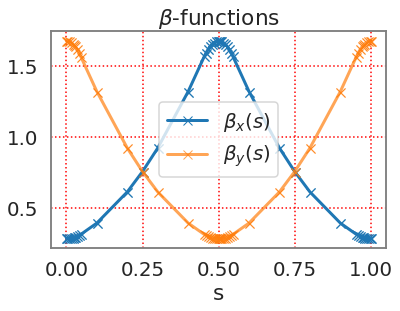

In [26]:
plt.title(r'$\beta$-functions')
plt.plot(twiss['s'], twiss['betx'], marker='x', label=r'$\beta_x(s)$')
plt.plot(twiss['s'], twiss['bety'], marker='x', label=r'$\beta_y(s)$', alpha=0.7)
plt.xlabel('s')
plt.legend();

# switch on synchrotron motion

In [27]:
madx.input('v := {}'.format(0.5 * rf_voltage * 1e-6)) # MV --> 0.5x because there are 2 cavities

++++++ info: v redefined


True

# Preparing PyHEADTAIL beam

In [28]:
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z,
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
    limit_n_rms_x=3.4**2, limit_n_rms_y=3.4**2, limit_n_rms_z=3.4**2,
)

In [29]:
distribution_z_uncut = generators.gaussian2D(
    sigma_z**2)

is_accepted = generators.make_is_accepted_within_n_sigma(
    epsn_rms=sigma_z,
    limit_n_rms=3.4,
)
distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

In [30]:
z, dp = distribution_z_cut(n_macroparticles)

pyht_beam.z, pyht_beam.dp = z, dp / beta_z

In [31]:
sigma_z

0.012282237792482364

In [32]:
pyht_beam.sigma_z()

0.012183065689564013

In [33]:
### match to space charge depressed bucket:

In [34]:
# matched_sigma_dp = 0.496e5 / (Etot * 1e9) / beta**2 # from Ji
# pyht_beam.dp *= matched_sigma_dp / pyht_beam.sigma_dp()

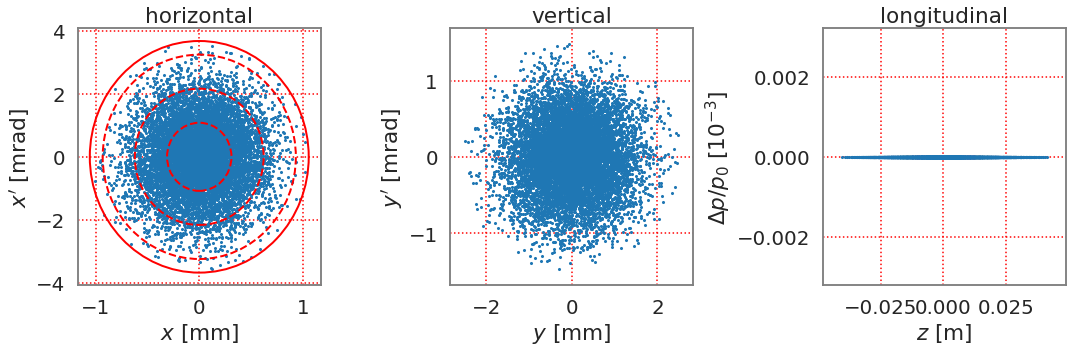

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal')
plt.scatter(pyht_beam.x[::100] * 1e3, pyht_beam.xp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [mrad]")

# plt.axvline(pyht_beam.sigma_x(), color='red')
# plt.axvline(2*pyht_beam.sigma_x(), color='red')
# plt.axvline(3*pyht_beam.sigma_x(), color='red')
# plt.axvline(3.4*pyht_beam.sigma_x(), color='red')

ep = mpl.patches.Ellipse(
    (0, 0), 2*pyht_beam.sigma_x() * 1e3, 2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 2*2*pyht_beam.sigma_x() * 1e3, 2*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 3*2*pyht_beam.sigma_x() * 1e3, 3*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 3.4*2*pyht_beam.sigma_x() * 1e3, 3.4*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='solid')
plt.gca().add_patch(ep)

plt.sca(ax[1])
plt.title('vertical')
plt.scatter(pyht_beam.y[::100] * 1e3, pyht_beam.yp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
plt.xlabel('$y$ [mm]')
plt.ylabel("$y'$ [mrad]")

plt.sca(ax[2])
plt.title('longitudinal')
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0$ [$10^{-3}$]")
plt.tight_layout()

# plt.savefig('particle_generation_phasespaces.png', dpi=150, bbox_inches='tight')

/home/oeftiger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


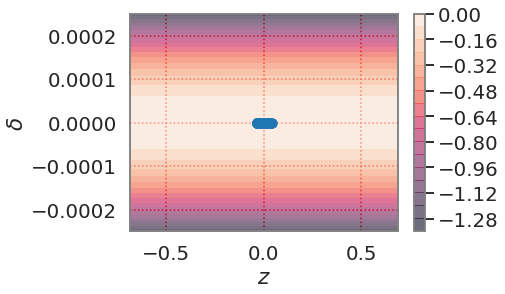

In [36]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [h], [rf_voltage], [np.pi])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.00025, 0.00025, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
plt.scatter(pyht_beam.z[::1000], pyht_beam.dp[::1000])
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [37]:
from PyHEADTAIL.spacecharge.spacecharge import LongSpaceCharge

In [38]:
slicer_long_sc = UniformBinSlicer(n_slices=1000, z_cuts=rfb.interval)

In [39]:
long_sc = LongSpaceCharge(slicer=slicer_long_sc, pipe_radius=10e-2, 
                          length=circumference, n_slice_sigma=5)

/home/oeftiger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


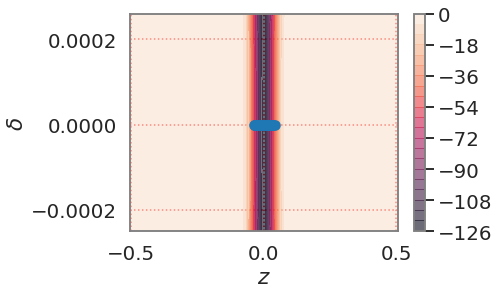

In [40]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [1], [rf_voltage], [np.pi])
rfb.add_fields([long_sc.make_force(pyht_beam)], [long_sc.make_potential(pyht_beam)])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.00025, 0.00026, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
plt.scatter(pyht_beam.z[::1000], pyht_beam.dp[::1000])
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [41]:
lmbda = intensity * e / (np.sqrt(2*np.pi) * sigma_z) * 0.682689 # 1 RMS
Ksc = e / (pyht_beam.gamma**3 * m_p * (pyht_beam.beta * c)**2) * lmbda / (2*np.pi*epsilon_0)
R = circumference / (2*np.pi)

def dQ_inc(thissize, theothersize, thistune, Ksc=Ksc):
    'incoherent KV tune shift'
    return Ksc * R**2 / (4 * thistune * thissize * (thissize+theothersize))

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_inc(pyht_beam.sigma_x(), pyht_beam.sigma_y(), Qx), 
    dQ_inc(pyht_beam.sigma_y(), pyht_beam.sigma_x(), Qy)))

dQ_x = 0.060 and dQ_y = 0.025


We want 79.6deg of SC suppressed cell phase advance:

In [42]:
(Qx - dQ_inc(np.sqrt(epsg_x * R / Qx), 
             np.sqrt(epsg_y * R / Qy), Qx)) * 360.

75.29120127026657

# Preparing PySTL for GPU

In [43]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [44]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [45]:
idx_mad_sc = [i for i, name in enumerate(madx.sequence.FODO.element_names()) 
              if 'sc_placeholder' in name]
sc_optics = {
    'beta_x': twiss['betx'][idx_mad_sc],
    'beta_y': twiss['bety'][idx_mad_sc],
    'D_x': twiss['dx'][idx_mad_sc],
    'D_y': twiss['dy'][idx_mad_sc],
    'x': twiss['x'][idx_mad_sc],
    'y': twiss['y'][idx_mad_sc],
    's': twiss['s'][idx_mad_sc]
}

In [46]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

# Interface to PyHEADTAIL

In [47]:
from pycuda import cumath

In [48]:
class TrackSixTrackLib(Element):
    '''General state.'''
    trackjob = None
    pointers = {}
    context = None
    n_elements = 0

    def __init__(self, trackjob, i_start, i_end, context=context):
        if TrackSixTrackLib.trackjob is None:
            TrackSixTrackLib.trackjob = trackjob

            trackjob.fetch_particle_addresses()
            assert trackjob.last_status_success
            ptr = trackjob.get_particle_addresses() # particleset==0 is default

            TrackSixTrackLib.pointers.update({
                'x': provide_pycuda_array(ptr.contents.x),
                'px': provide_pycuda_array(ptr.contents.px),
                'y': provide_pycuda_array(ptr.contents.y),
                'py': provide_pycuda_array(ptr.contents.py),
                'z': provide_pycuda_array(ptr.contents.zeta),
                'delta': provide_pycuda_array(ptr.contents.delta),
                'rpp': provide_pycuda_array(ptr.contents.rpp),
                'psigma': provide_pycuda_array(ptr.contents.psigma),
                'rvv': provide_pycuda_array(ptr.contents.rvv),
            })
            TrackSixTrackLib.n_elements = len(trackjob.beam_elements_buffer.get_elements())

        self.i_start = i_start
        self.i_end = i_end
        self.is_last_element = (i_end == self.n_elements)

        self.context = context

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        # to be replaced by barrier:
        trackjob.collectParticlesAddresses()

        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        self.memcpy(self.pointers['x'], beam.x)
        self.memcpy(self.pointers['px'], beam.xp)
        self.memcpy(self.pointers['y'], beam.y)
        self.memcpy(self.pointers['py'], beam.yp)
        self.memcpy(self.pointers['z'], beam.z)
        self.memcpy(self.pointers['delta'], beam.dp)
        
        # further longitudinal coordinates of SixTrackLib
        rpp = 1. / (beam.dp + 1)
        self.memcpy(self.pointers['rpp'], rpp)

        restmass = beam.mass * c**2
        restmass_sq = restmass**2
        E0 = np.sqrt((beam.p0 * c)**2 + restmass_sq)
        p = beam.p0 * (1 + beam.dp)
        E = cumath.sqrt((p * c) * (p * c) + restmass_sq)
        psigma =  (E - E0) / (beam.beta * beam.p0 * c)
        self.memcpy(self.pointers['psigma'], psigma)
                    
        gamma = E / restmass
        beta = cumath.sqrt(1 - 1. / (gamma * gamma))
        rvv = beta / beam.beta
        self.memcpy(self.pointers['rvv'], rvv)
        
        self.context.synchronize()

    @staticmethod
    def memcpy(dest, src):
        '''device memory copy with pycuda from src GPUArray to dest GPUArray.'''
#         dest[:] = src
#         memcpy_atoa(dest, 0, src, 0, len(src))
        memcpy_dtod_async(dest.gpudata, src.gpudata, src.nbytes)

    def stlib_to_pyht(self, beam):
        beam.x = self.pointers['x']
        beam.xp = self.pointers['px']
        beam.y = self.pointers['y']
        beam.yp = self.pointers['py']
        beam.z = self.pointers['z']
        beam.dp = self.pointers['delta']

# Prepare PyHEADTAIL style one-turn map

In [49]:
def rms_beam_size(beta_optics, epsn, disp_optics, 
                  sigma_dp=pyht_beam.sigma_dp(), beta=beta, gamma=gamma):
    return np.sqrt(beta_optics * epsn / (beta * gamma) + (disp_optics * sigma_dp)**2)

In [50]:
sig_x = rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).max()
sig_y = rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).max()

In [51]:
print ('The smallest horizontal beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_x - rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).min()) / sig_x * 100))

print ('The smallest vertical beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_y - rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).min()) / sig_y * 100))

The smallest horizontal beam size is 58.31% smaller than the largest beam size.
The smallest vertical beam size is 58.19% smaller than the largest beam size.


In [52]:
slicer_sc = UniformBinSlicer(n_slices_sc, n_sigma_z=4) #z_cuts=slicing_interval)

In [53]:
slices = pyht_beam.get_slices(slicer_sc)
assert not any(slices.particles_outside_cuts)

Use the maximum size needed for the transverse grid:

In [54]:
# mesh_3d = create_3dmesh_from_beam(pyht_beam, [n_mesh_nodes]*2, [n_mesh_sigma]*2, 
#                                   slices=pyht_beam.get_slices(slicer_sc))

mesh_origin = [-n_mesh_sigma * sig_x, 
               -n_mesh_sigma * sig_y]
mesh_distances = [2 * n_mesh_sigma * sig_x / n_mesh_nodes, 
                  2 * n_mesh_sigma * sig_y / n_mesh_nodes]
mesh_3d = create_mesh(mesh_origin, mesh_distances, [n_mesh_nodes]*2, slices=slices)

In [55]:
# poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
poissonsolver = GPUFFTPoissonSolver(mesh_3d, context=context)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)

# <span style='color:red;'>vvv Removing longitudinal SC kick from 3D algorithm vvv</span>

In [56]:
class SpaceChargePIC_NoLongKick(SpaceChargePIC):
    '''Simply removes the longitudinal kick.'''
    def track(self, beam):
        dp0 = beam.dp.copy()
        super(SpaceChargePIC_NoLongKick, self).track(beam)
        beam.dp = dp0

# <span style='color:red;'>vvv Removing longitudinal drift from `SixTrackLib` vvv</span>

In [57]:
class TrackSixTrackLib_NoLongDrift(TrackSixTrackLib):
    '''Simply undoes the longitudinal drift.'''
    def track(self, beam):
        z0 = beam.z.copy()
        super(TrackSixTrackLib_NoLongDrift, self).track(beam)
        beam.z = z0

In [58]:
sum(el.length for el in elements.get_elements() if isinstance(el, pyst.DriftExact))

1.0

In [59]:
one_turn_map = []

relevant_elements = elements.get_elements()

if isinstance(elements.get_elements()[-1], pyst.BeamMonitor):
    relevant_elements = relevant_elements[:-1]

i_last = 0
length_covered = 0
for i_curr, el in enumerate(relevant_elements):
    if not isinstance(el, pyst.DriftExact):
        continue
    length_covered += el.length

    #i_curr == 0 or 
    if el.length != 0 : # only inject SC node at markers (for SC)
        continue

    pyst_node = TrackSixTrackLib_NoLongDrift(trackjob, i_last, i_curr + 1, context=context)
    one_turn_map.append(pyst_node)

    sc_node = SpaceChargePIC_NoLongKick(length_covered, pypic_algorithm)
    one_turn_map.append(sc_node)

    i_last = i_curr
    length_covered = 0

assert pyst_node.i_end == len(relevant_elements)
assert el._offset == relevant_elements[-1]._offset
assert isinstance(el, pyst.DriftExact)
assert el.length == 0

pyst_node.is_last_element = True

# Tracking space charge and full optics:

In [60]:
alpha_x = twiss['alfx'][0]
beta_x = twiss['betx'][0]
alpha_y = twiss['alfy'][0]
beta_y = twiss['bety'][0]

In [61]:
def get_action(u, up, dp=None, alpha_twiss=0, beta_twiss=1, disp=0):
    if disp and dp.any():
        u = u - disp * dp
    gamma_twiss = (1 + alpha_twiss**2) / beta_twiss
    J = 0.5 * (gamma_twiss * u**2 + 2*alpha_twiss * u * up + beta_twiss * up**2)
    return J

In [62]:
import PyHEADTAIL.gpu.thrust_interface as thrust

def gpu_sort(ary):
    sortd = ary.copy() # thrust sorts in place
    thrust.sort_double(sortd)
    return sortd

pm._CPU_numpy_func_dict['sort'] = np.sort
pm._GPU_func_dict['sort'] = gpu_sort

pm.update_active_dict(pm._CPU_numpy_func_dict)

In [63]:
J_quantiles = np.arange(0, 1, 0.05) + 0.05

J_quantiles_ids = list((J_quantiles * n_macroparticles).astype(int) - 1)

def get_J_xy_quantiles(
        pyht_beam, J_quantiles_ids=J_quantiles_ids, 
        alpha_x=alpha_x, alpha_y=alpha_y, 
        beta_x=beta_x, beta_y=beta_y):    
    J_x = get_action(pyht_beam.x, pyht_beam.xp, alpha_twiss=alpha_x, beta_twiss=beta_x)
    J_x_quantiles = pm.ensure_CPU(pm.sort(J_x))[J_quantiles_ids]

    J_y = get_action(pyht_beam.y, pyht_beam.yp, alpha_twiss=alpha_y, beta_twiss=beta_y)
    J_y_quantiles = pm.ensure_CPU(pm.sort(J_y))[J_quantiles_ids]
    return J_x_quantiles, J_y_quantiles

In [64]:
n_turns = 5000 #128 - 1 #
n_stored_particles = 1000

bunchmon = BunchMonitor('bunchmonitor', n_turns + 1, write_buffer_every=1)
partmon = ParticleMonitor('particlemonitor', stride=n_macroparticles // n_stored_particles)

# emittance quantiles evolution
rec_epsn_q_x = np.empty((n_turns + 1, len(J_quantiles)), dtype=float)
rec_epsn_q_y = np.empty_like(rec_epsn_q_x)

J_x, J_y = get_J_xy_quantiles(pyht_beam)
rec_epsn_q_x[0, :] = beta * gamma * J_x
rec_epsn_q_y[0, :] = beta * gamma * J_y

with GPU(pyht_beam):
    bunchmon.dump(pyht_beam)
    partmon.dump(pyht_beam)

    for i in range(1, n_turns+1):
        for m in one_turn_map:
            m.track(pyht_beam)

        bunchmon.dump(pyht_beam)
        
        pyht_beam.sort_for('id')
        partmon.dump(pyht_beam)

        J_x, J_y = get_J_xy_quantiles(pyht_beam)
        rec_epsn_q_x[i, :] = beta * gamma * J_x
        rec_epsn_q_y[i, :] = beta * gamma * J_y
        
        sys.stdout.write('\rTurn {}/{}'.format(i, n_turns))

Turn 5000/5000

# Save simulation results

In [65]:
pickle.dump(pyht_beam, open('beam.p', 'wb'))

In [66]:
np.save('results_epsn_quantiles_x', rec_epsn_q_x)
np.save('results_epsn_quantiles_y', rec_epsn_q_y)

# Load simulation results

In [67]:
pyht_beam = pickle.load(open('beam.p', 'rb'))

In [68]:
rec_epsn_q_x = np.load('results_epsn_quantiles_x.npy')
rec_epsn_q_y = np.load('results_epsn_quantiles_y.npy')

In [69]:
with h5py.File('particlemonitor.h5part', 'r') as fp:
    n_steps = len([st for st in fp.keys() if 'Step' in st])
    n_stored_particles = len(fp['Step#0']['x'])
    
    rec_inc_x = np.empty((n_steps, n_stored_particles), dtype=np.float32)
    rec_inc_xp = np.empty_like(rec_inc_x)
    rec_inc_y = np.empty_like(rec_inc_x)
    rec_inc_yp = np.empty_like(rec_inc_x)
    rec_inc_z = np.empty_like(rec_inc_x)
    rec_inc_dp = np.empty_like(rec_inc_x)
    
    for i in range(n_steps):
        rec_inc_x[i, :] = fp['Step#{}'.format(i)]['x']
        rec_inc_xp[i, :] = fp['Step#{}'.format(i)]['xp']
        rec_inc_y[i, :] = fp['Step#{}'.format(i)]['y']
        rec_inc_yp[i, :] = fp['Step#{}'.format(i)]['yp']
        rec_inc_z[i, :] = fp['Step#{}'.format(i)]['z']
        rec_inc_dp[i, :] = fp['Step#{}'.format(i)]['dp']

In [70]:
with h5py.File('bunchmonitor.h5', 'r') as fb:
    rec_mean_x = np.array(fb['Bunch']['mean_x'])
    rec_mean_y = np.array(fb['Bunch']['mean_y'])
    rec_epsn_x = np.array(fb['Bunch']['epsn_x'])
    rec_epsn_y = np.array(fb['Bunch']['epsn_y'])

In [71]:
rec_epsn100_x = rec_epsn_q_x[:, -1]
rec_epsn100_y = rec_epsn_q_y[:, -1]

# Basic consistency checks

## No particles left the grid:

Cross-checking the amplitudes of the particles, ensuring that they remain within what the transverse PIC grid covers:

In [72]:
grid_x_action = get_action(sc_node.pypic.mesh.x0, 0, beta_twiss=beta_x)

In [73]:
J_x = get_action(pyht_beam.x, pyht_beam.xp, alpha_twiss=alpha_x, beta_twiss=beta_x)
id_max = np.argmax(J_x)

assert J_x[id_max] < grid_x_action, 'largest horizontal amplitude particle is off the grid!'

In [74]:
grid_y_action = get_action(sc_node.pypic.mesh.y0, 0, beta_twiss=beta_y)

In [75]:
J_y = get_action(pyht_beam.y, pyht_beam.yp, alpha_twiss=alpha_y, beta_twiss=beta_y)
id_max = np.argmax(J_y)

assert J_y[id_max] < grid_y_action, 'largest vertical amplitude particle is off the grid!'

In [76]:
grid_z_action = get_action(sc_node.pypic.mesh.z0, 0, beta_twiss=beta_z)

In [77]:
J_z = get_action(pyht_beam.z, pyht_beam.dp, alpha_twiss=0, beta_twiss=beta_z)
id_max = np.argmax(J_z)

assert J_z[id_max] < grid_z_action, 'largest longitudinal amplitude particle is off the grid!'

## All particles alive:

No particles met the 1m global aperture of SixTrackLib:

In [78]:
all(pyst_beam.state)

True

Numerical cross-check: no particles acquired $\equiv 0$ coordinate or momentum values (all remain finite):

In [79]:
assert all([all(pyht_beam.x), all(pyht_beam.xp), all(pyht_beam.y), all(pyht_beam.yp), all(pyht_beam.z)])

# Centroid cross-check

The transverse centroid motion shows no irregularity:

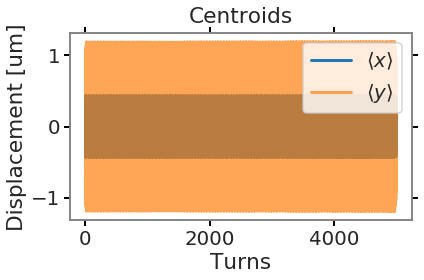

In [80]:
plt.plot(rec_mean_x * 1e6, label=r'$\langle x \rangle$')
plt.plot(rec_mean_y * 1e6, label=r'$\langle y \rangle$', alpha=0.7)
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Displacement [um]')
plt.title('Centroids', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_centroids.png', dpi=150, bbox_inches='tight')

The sum of all kicks in horizontal (and any other plane) vanishes to machine precision (3rd Newton law, $\text{actio} = \text{reactio}$ $\implies$ space charge as a self-force should not move the centre-of-gravity), i.e. no influence of direct space charge on the centroid:

In [81]:
with GPU(pyht_beam):
    pyht_beam.sort_for('id')
    xp0 = pyht_beam.xp.copy()
    
    sc_node.track(pyht_beam)
    
    pyht_beam.sort_for('id')
    xp1 = pyht_beam.xp.copy()

In [82]:
gp.sum(xp1 - xp0)

array(1.91686944e-16)

In [83]:
pyht_beam = pickle.load(open('./beam.p', 'rb'))

In [84]:
n_turns = 5000

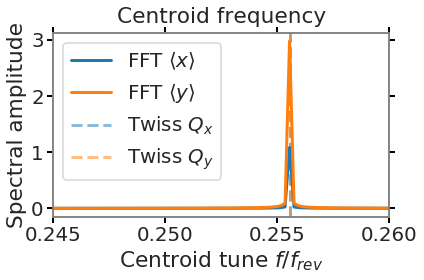

In [85]:
current_palette = sns.color_palette()
plt.plot(np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_mean_x)) * 1e3, label=r'FFT $\langle x \rangle$')
plt.plot(np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_mean_y)) * 1e3, label=r'FFT $\langle y \rangle$')
plt.axvline(twiss.summary['q1']%1, color=current_palette[0], ls='--', alpha=0.5, zorder=-1, label='Twiss $Q_x$')
plt.axvline(twiss.summary['q2']%1, color=current_palette[1], ls='--', alpha=0.5, zorder=-1, label='Twiss $Q_y$')
plt.xlim(0.245, 0.26)
plt.legend()
plt.xlabel('Centroid tune $f/f_{rev}$')
plt.ylabel('Spectral amplitude')
plt.title('Centroid frequency', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_centroidspectra.png', dpi=150, bbox_inches='tight')

$~$

$~$

$~$

$~$

$~$

# ====] Results [====

# Emittance evolution

RMS emittances grow by a factor $\approx 1.5$:

In [86]:
pyht_beam.epsn_x() / epsn_x

1.1600992461340789

In [87]:
pyht_beam.epsn_y() / epsn_y

1.1393992864281628

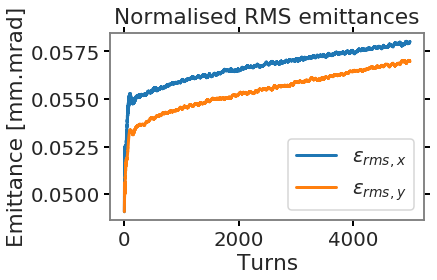

In [88]:
plt.plot(rec_epsn_x * 1e6, label=r'$\epsilon_{rms,x}$')
plt.plot(rec_epsn_y * 1e6, label=r'$\epsilon_{rms,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Normalised RMS emittances', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsnxy.png', dpi=150, bbox_inches='tight')

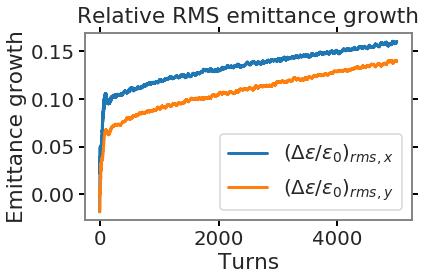

In [89]:
plt.plot((rec_epsn_x - epsn_x) / epsn_x, label=r'$(\Delta \epsilon/\epsilon_0)_{rms,x}$')
plt.plot((rec_epsn_y - epsn_y) / epsn_y, label=r'$(\Delta \epsilon/\epsilon_0)_{rms,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance growth')
plt.title('Relative RMS emittance growth', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsnxy_rel.png', dpi=150, bbox_inches='tight')

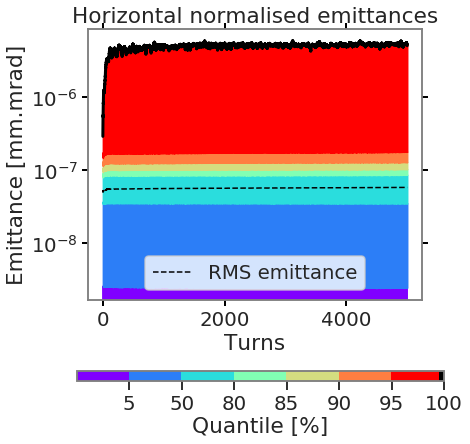

In [90]:
J_chosen_ids = [0, 9, 15, 16, 17, 18, 19]

NUM_COLORS = len(J_chosen_ids)
cm = plt.get_cmap('rainbow')

i_cgen = [cm(1.*i/float(NUM_COLORS - 1)) for i in range(NUM_COLORS)]

plt.figure(figsize=(6, 5))

last_J_idx = J_chosen_ids[0]
plt.fill_between(np.arange(len(rec_epsn_q_x)),
                 0,
                 rec_epsn_q_x[:, last_J_idx],
                 color=i_cgen[0])

for J_idx, col in zip(J_chosen_ids[1:], i_cgen[1:]):
    plt.fill_between(np.arange(len(rec_epsn_q_x)),
                     rec_epsn_q_x[:, last_J_idx],
                     rec_epsn_q_x[:, J_idx],
                     color=col)
    last_J_idx = J_idx

plt.plot(rec_epsn_q_x[:, last_J_idx], color='black')

plt.plot(rec_epsn_x, color='black', ls='--', lw=1.5, label='RMS emittance')
plt.legend(loc=8)

plt.yscale('log')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='none')

plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Horizontal normalised emittances')

cmap = cm.from_list('Custom cmap', i_cgen, NUM_COLORS)
bounds = np.concatenate(([0], J_quantiles[J_chosen_ids]*100))
norm = mpl.colors.BoundaryNorm(bounds, NUM_COLORS)

ax2 = plt.gcf().add_axes([0.1, -0.1, 0.85, 0.03])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, #spacing='proportional', 
                               boundaries=bounds,
                               ticks=J_quantiles[J_chosen_ids]*100, orientation='horizontal')
cb.set_label('Quantile [%]')
ax2.axvline(1, color='black', lw=10)
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsn_quantiles_x.png', dpi=150, bbox_inches='tight')

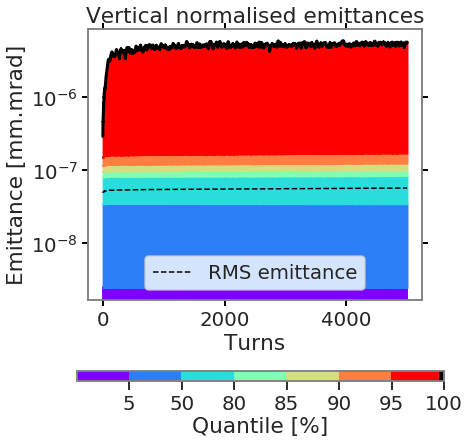

In [91]:
J_chosen_ids = [0, 9, 15, 16, 17, 18, 19]

NUM_COLORS = len(J_chosen_ids)
cm = plt.get_cmap('rainbow')

i_cgen = [cm(1.*i/float(NUM_COLORS - 1)) for i in range(NUM_COLORS)]

plt.figure(figsize=(6, 5))

last_J_idx = J_chosen_ids[0]
plt.fill_between(np.arange(len(rec_epsn_q_y)),
                 0,
                 rec_epsn_q_y[:, last_J_idx],
                 color=i_cgen[0])

for J_idx, col in zip(J_chosen_ids[1:], i_cgen[1:]):
    plt.fill_between(np.arange(len(rec_epsn_q_y)),
                     rec_epsn_q_y[:, last_J_idx],
                     rec_epsn_q_y[:, J_idx],
                     color=col)
    last_J_idx = J_idx

plt.plot(rec_epsn_q_y[:, last_J_idx], color='black')

plt.plot(rec_epsn_y, color='black', ls='--', lw=1.5, label='RMS emittance')
plt.legend(loc=8)

plt.yscale('log')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='none')

plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Vertical normalised emittances')

cmap = cm.from_list('Custom cmap', i_cgen, NUM_COLORS)
bounds = np.concatenate(([0], J_quantiles[J_chosen_ids]*100))
norm = mpl.colors.BoundaryNorm(bounds, NUM_COLORS)

ax2 = plt.gcf().add_axes([0.1, -0.1, 0.85, 0.03])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, #spacing='proportional', 
                               boundaries=bounds,
                               ticks=J_quantiles[J_chosen_ids]*100, orientation='horizontal')
cb.set_label('Quantile [%]')
ax2.axvline(1, color='black', lw=10)
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsn_quantiles_y.png', dpi=150, bbox_inches='tight')

$\implies$ around the 80% emittance, the particles start to be dragged into the resonance, below the contours stay relatively constant and only grow slightly.

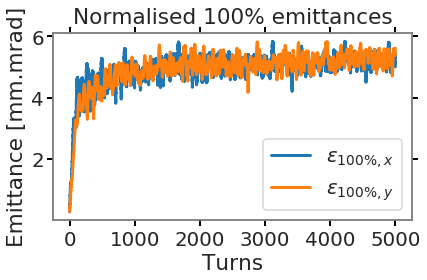

In [92]:
plt.plot(rec_epsn100_x * 1e6, label=r'$\epsilon_{100\%,x}$')
plt.plot(rec_epsn100_y * 1e6, label=r'$\epsilon_{100\%,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Normalised 100% emittances', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsn100xy.png', dpi=150, bbox_inches='tight')

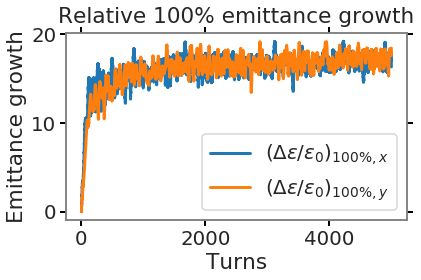

In [93]:
plt.plot((rec_epsn100_x - rec_epsn100_x[0]) / rec_epsn100_x[0],
         label=r'$(\Delta \epsilon/\epsilon_0)_{100\%,x}$')
plt.plot((rec_epsn100_y - rec_epsn100_y[0]) / rec_epsn100_y[0],
         label=r'$(\Delta \epsilon/\epsilon_0)_{100\%,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance growth')
plt.title('Relative 100% emittance growth', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsn100xy_rel.png', dpi=150, bbox_inches='tight')

# Longitudinal motion

Incoherent synchrotron tune distribution:

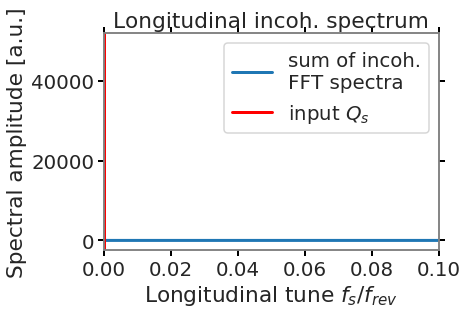

In [94]:
plt.plot(np.fft.rfftfreq(len(rec_inc_z)), np.sum(np.abs(np.fft.rfft(rec_inc_z, axis=0)), axis=1), 
         label='sum of incoh.\nFFT spectra');
plt.axvline(Qs, color='red', label='input $Q_s$')
plt.xlim(0, 0.1)
plt.legend()
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.title('Longitudinal incoh. spectrum')
plt.xlabel('Longitudinal tune $f_s/f_{rev}$')
plt.ylabel('Spectral amplitude [a.u.]')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_long_spectrum.png', dpi=150, bbox_inches='tight')

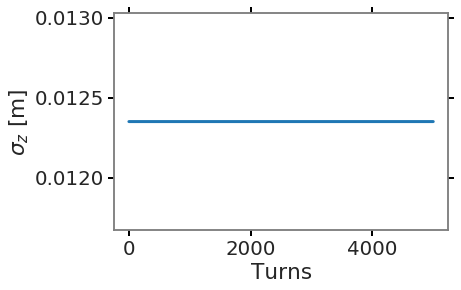

In [95]:
plt.plot(np.std(rec_inc_z, axis=1))
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.xlabel('Turns')
plt.ylabel(r'$\sigma_z$ [m]')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_sigmaz.png', dpi=150, bbox_inches='tight')

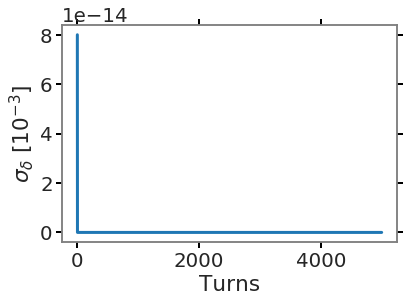

In [96]:
plt.plot(np.std(rec_inc_dp * 1e3, axis=1))
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.xlabel('Turns')
plt.ylabel(r'$\sigma_\delta$ [$10^{-3}$]')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_sigmadp.png', dpi=150, bbox_inches='tight')

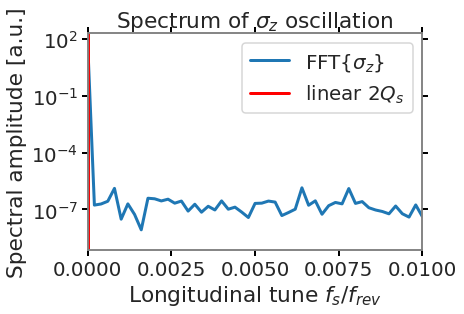

In [97]:
plt.plot(np.fft.rfftfreq(len(rec_inc_z)), np.abs(np.fft.rfft(np.std(rec_inc_z, axis=1))),
         label='FFT$\{\sigma_z\}$')
plt.yscale('log')
plt.axvline(2*Qs, color='red', label='linear $2Q_s$')
plt.legend()
plt.xlim(0, 2*Qs + 0.01)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.xlabel('Longitudinal tune $f_s/f_{rev}$')
plt.ylabel('Spectral amplitude [a.u.]')
plt.title(r'Spectrum of $\sigma_z$ oscillation')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_sigmaz_spectrum.png', dpi=150, bbox_inches='tight')

/home/oeftiger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


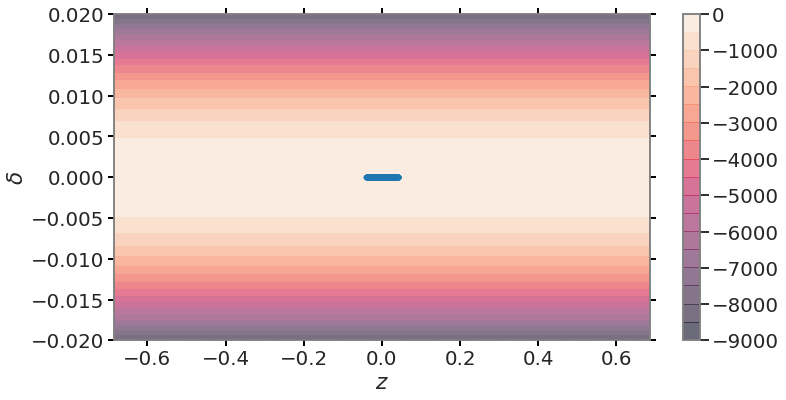

In [98]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [h], [rf_voltage], [np.pi])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.02, 0.02, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)

plt.figure(figsize=(12, 6))
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100], marker='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_longphasespace.png', dpi=150, bbox_inches='tight')

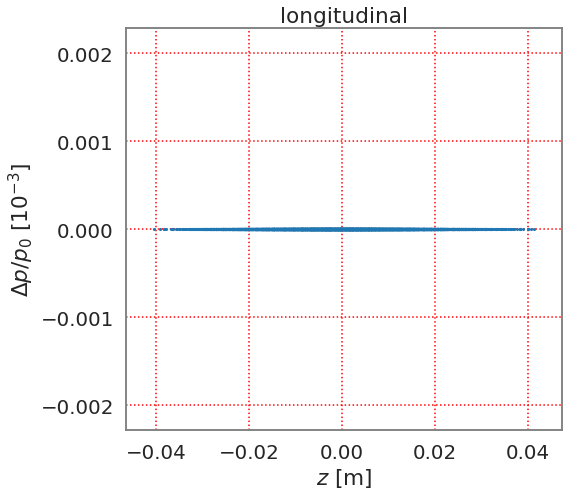

In [99]:
plt.figure(figsize=(8, 7))
plt.title('longitudinal')
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0$ [$10^{-3}$]")
plt.tight_layout()

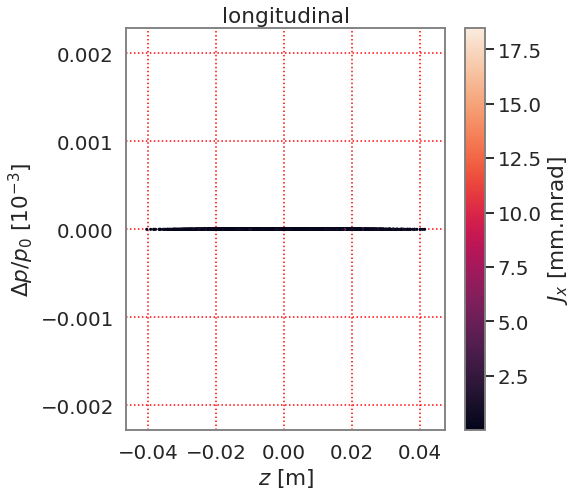

In [100]:
plt.figure(figsize=(8, 7))
plt.title('longitudinal')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0$ [$10^{-3}$]")
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.',
            c=get_action(pyht_beam.x[::100], pyht_beam.xp[::100], 
                         alpha_twiss=alpha_x, beta_twiss=beta_x) * 1e6)
cbar = plt.colorbar()
cbar.set_label('$J_x$ [mm.mrad]')
plt.tight_layout()

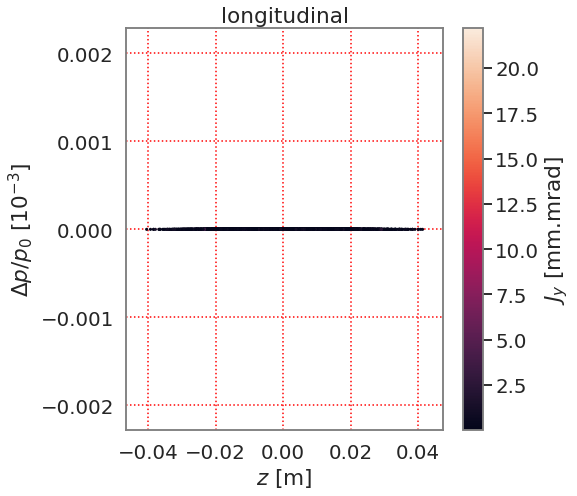

In [101]:
plt.figure(figsize=(8, 7))
plt.title('longitudinal')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0$ [$10^{-3}$]")
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.',
            c=get_action(pyht_beam.y[::100], pyht_beam.yp[::100], 
                         alpha_twiss=alpha_y, beta_twiss=beta_y) * 1e6)
cbar = plt.colorbar()
cbar.set_label('$J_y$ [mm.mrad]')
plt.tight_layout()

$\implies$ outer longitudinal halo particles do not seem correlated with transverse action

Final longitudinal bunch profile:

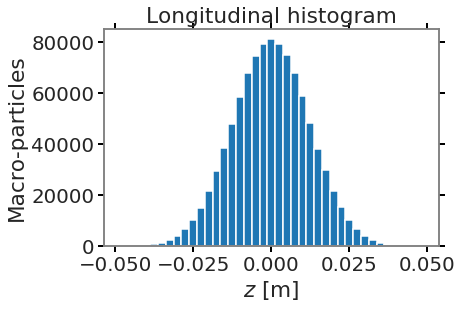

In [102]:
plt.hist(pyht_beam.z, bins=np.linspace(-pyht_beam.sigma_z()*4, pyht_beam.sigma_z()*4, 40));
plt.xlabel('$z$ [m]')
plt.ylabel('Macro-particles')
plt.title('Longitudinal histogram')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_longprofile.png', dpi=150, bbox_inches='tight')

# Beam phase space

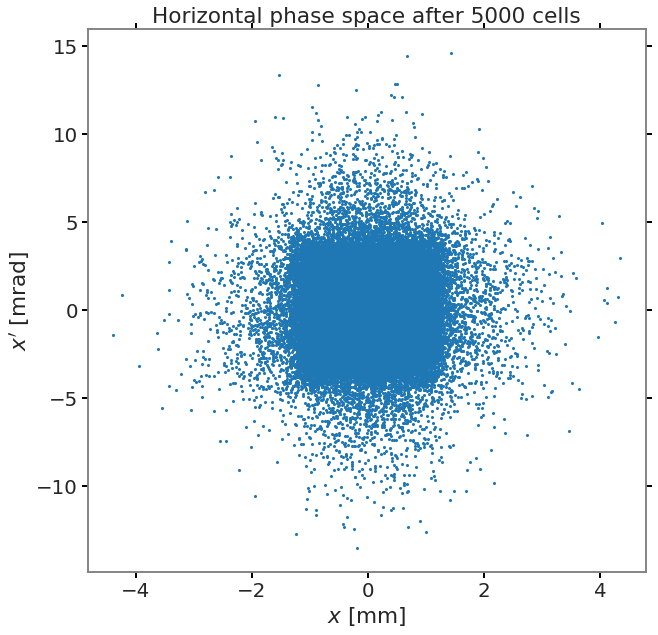

In [103]:
plt.figure(figsize=(10, 10))
plt.scatter(pyht_beam.x * 1e3, pyht_beam.xp * 1e3, marker='.', s=10)
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Horizontal phase space after 5000 cells')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_x.png', dpi=150, bbox_inches='tight')

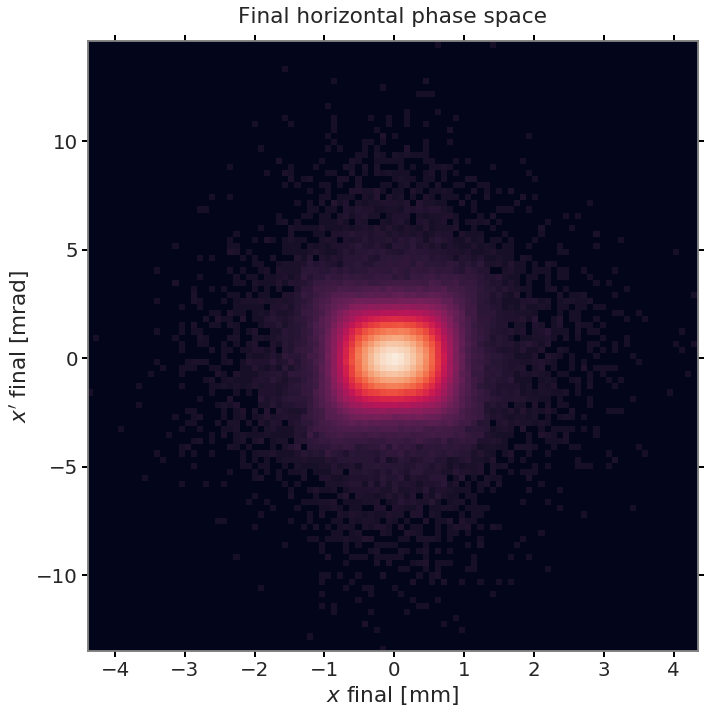

In [104]:
plt.figure(figsize=(10, 10))
plt.hist2d(pyht_beam.x*1e3, pyht_beam.xp*1e3, bins=100, norm=mcolors.PowerNorm(0.3))
plt.xlabel('$x$ final [mm]')
plt.ylabel('$x\'$ final [mrad]')
plt.title('Final horizontal phase space', y=1.02)
plt.gca().set_aspect(np.diff(plt.xlim()) / np.diff(plt.ylim()))
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_bunch.png', dpi=150, bbox_inches='tight')

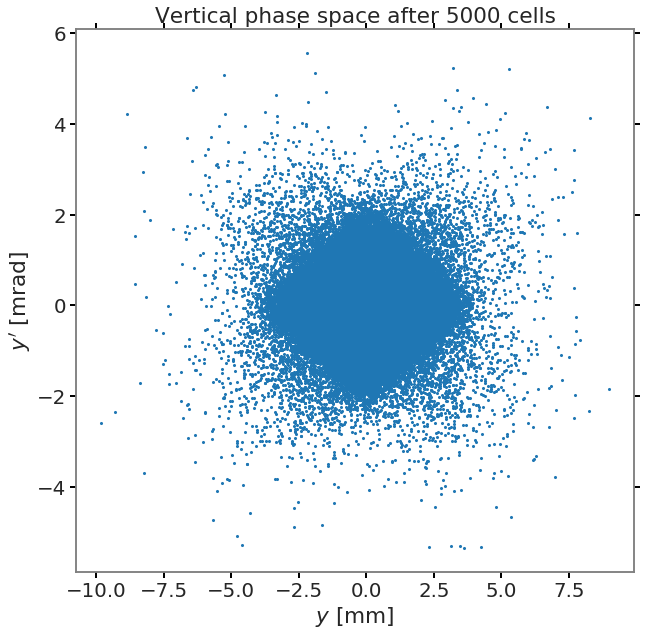

In [105]:
plt.figure(figsize=(10, 10))
plt.scatter(pyht_beam.y * 1e3, pyht_beam.yp * 1e3, marker='.', s=10)
plt.xlabel('$y$ [mm]')
plt.ylabel(r"$y'$ [mrad]")
plt.title('Vertical phase space after 5000 cells')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_y.png', dpi=150, bbox_inches='tight')

Looking in particular at the central slice located at the peak line charge density:

In [106]:
slices = pyht_beam.get_slices(slicer_sc)

peak_ids = slices.particle_indices_of_slice(slicer_sc.n_slices // 2)

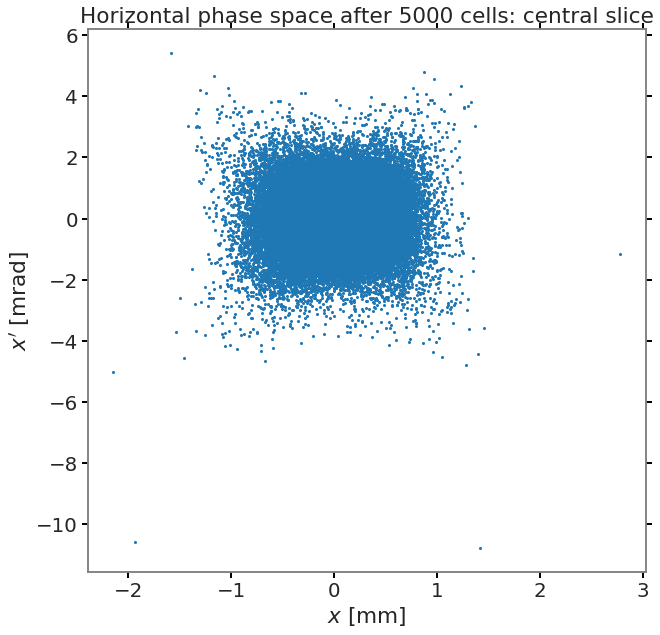

In [107]:
plt.figure(figsize=(10, 10))
plt.scatter(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, marker='.', s=10)
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Horizontal phase space after 5000 cells: central slice')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_x_core.png', dpi=150, bbox_inches='tight')

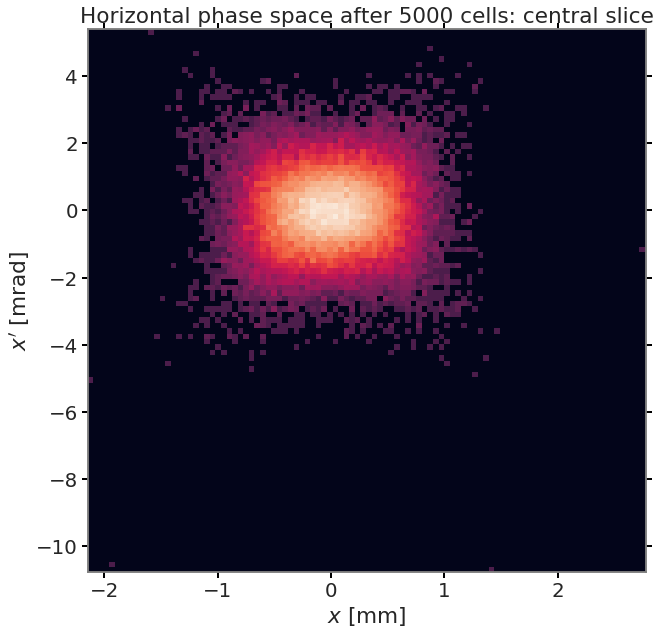

In [108]:
plt.figure(figsize=(10, 10))
plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100, norm=mcolors.PowerNorm(0.3))
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Horizontal phase space after 5000 cells: central slice')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_x_core_hist.png', dpi=150, bbox_inches='tight')

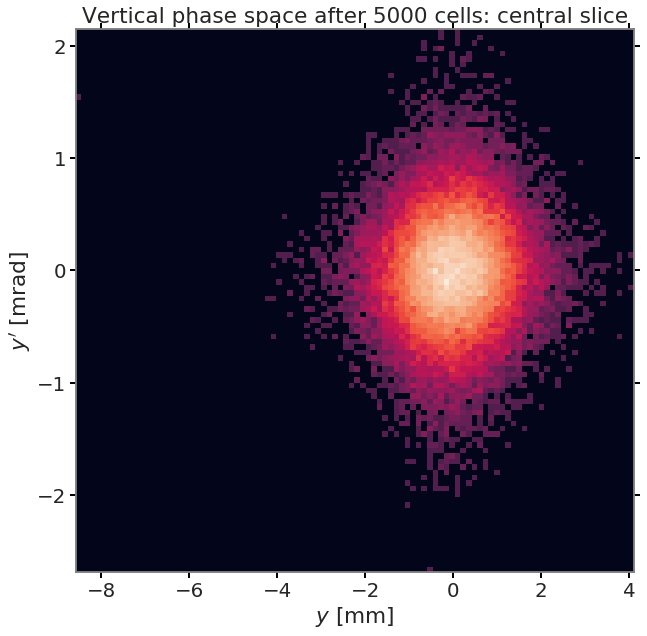

In [109]:
plt.figure(figsize=(10, 10))
plt.hist2d(pyht_beam.y[peak_ids] * 1e3, pyht_beam.yp[peak_ids] * 1e3, bins=100, norm=mcolors.PowerNorm(0.3))
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$y$ [mm]')
plt.ylabel(r"$y'$ [mrad]")
plt.title('Vertical phase space after 5000 cells: central slice')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_y_core_hist.png', dpi=150, bbox_inches='tight')

# Highest action particle: Poincare section

maximum $x$ amplitude of recorded particles:

In [110]:
np.sqrt(get_action(rec_inc_x[-1], rec_inc_xp[-1], alpha_twiss=alpha_x, beta_twiss=beta_x).max() * 2 * beta_x)

0.0020239674705627817

In [111]:
id_max = np.argmax(get_action(rec_inc_x[-1], rec_inc_xp[-1], alpha_twiss=alpha_x, beta_twiss=beta_x))

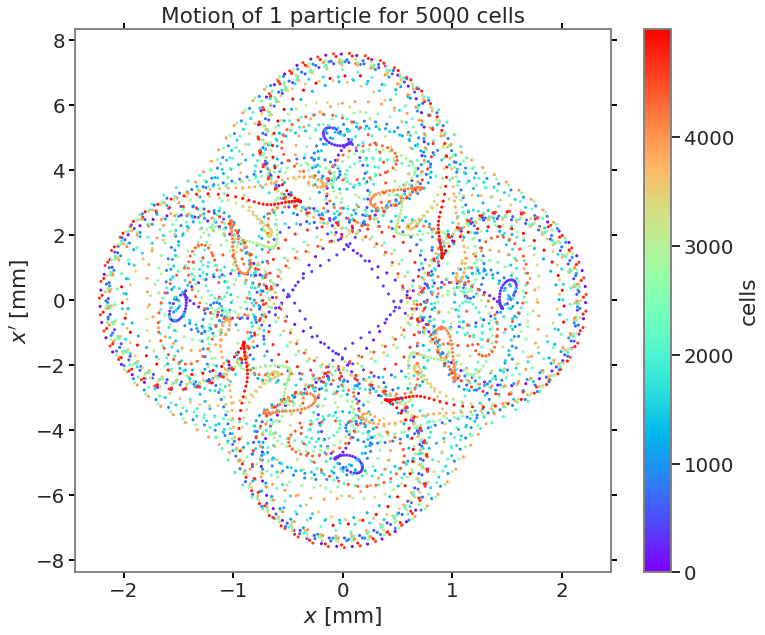

In [112]:
plt.figure(figsize=(12, 10))
plt.scatter(rec_inc_x[3:, id_max] * 1e3, rec_inc_xp[3:, id_max] * 1e3, marker='.', 
            s=10, c=np.arange(len(rec_inc_x[3:, id_max])), cmap=plt.get_cmap('rainbow'))
cbar = plt.colorbar()
cbar.set_label('cells')
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mm]")
plt.title('Motion of 1 particle for 5000 cells')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_particlemotion.png', dpi=150, bbox_inches='tight')

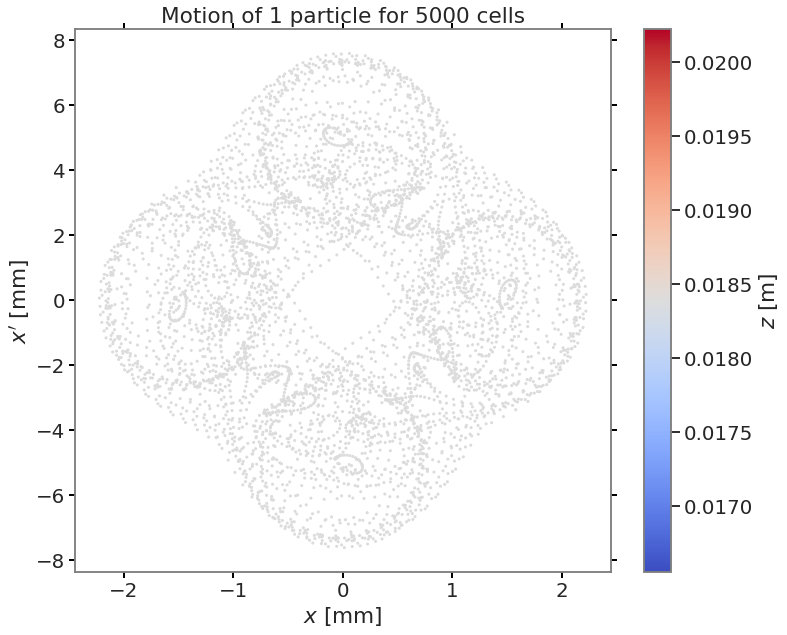

In [113]:
plt.figure(figsize=(12, 10))
plt.scatter(rec_inc_x[:, id_max] * 1e3, rec_inc_xp[:, id_max] * 1e3, marker='.', 
            s=10, c=rec_inc_z[:, id_max], cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar()
cbar.set_label('$z$ [m]')
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mm]")
plt.title('Motion of 1 particle for 5000 cells')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_particlemotion_z.png', dpi=150, bbox_inches='tight')

The 100th highest action particle phase space:

In [114]:
id_interm = np.argsort(-get_action(rec_inc_x[-1], rec_inc_xp[-1], alpha_twiss=alpha_x, beta_twiss=beta_x))[100]

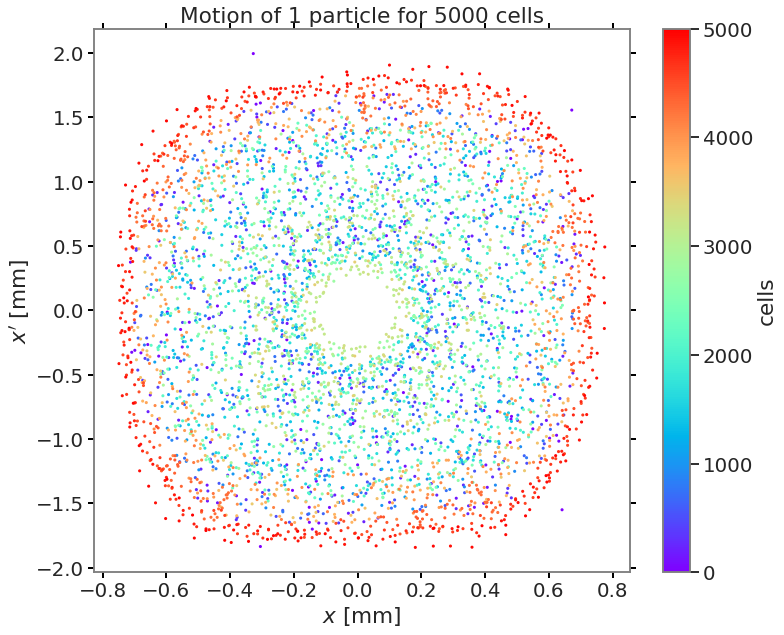

In [115]:
plt.figure(figsize=(12, 10))
plt.scatter(rec_inc_x[:, id_interm] * 1e3, rec_inc_xp[:, id_interm] * 1e3, marker='.', 
            s=10, c=np.arange(len(rec_inc_x[:, id_interm])), cmap=plt.get_cmap('rainbow'))
cbar = plt.colorbar()
cbar.set_label('cells')
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mm]")
plt.title('Motion of 1 particle for 5000 cells')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_particlemotion_interm.png', dpi=150, bbox_inches='tight')

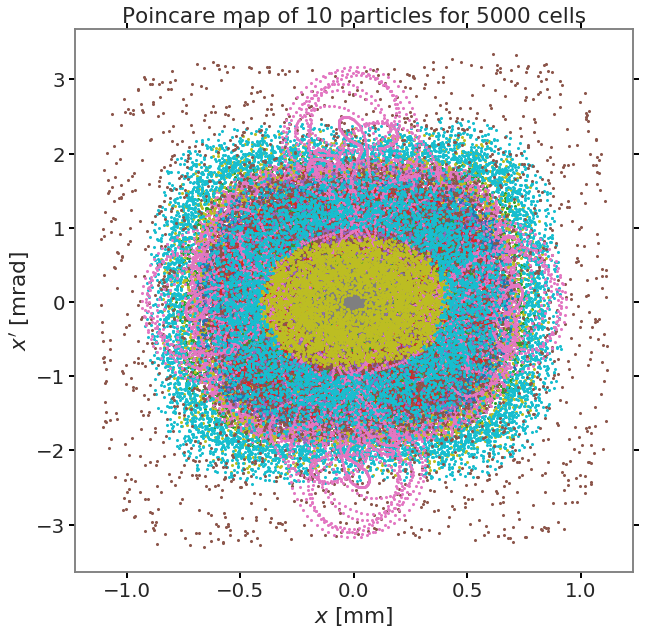

In [116]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.scatter(rec_inc_x[:, i] * 1e3, rec_inc_xp[:, i] * 1e3, marker='.', s=10)
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);

# plt.axvline(mesh_3d.x0 * 1e3, color='black', ls=':')
# plt.axhline(mesh_3d.y0 * 1e3, color='black', ls=':')
# plt.axvline(-mesh_3d.x0 * 1e3, color='black', ls=':')
# plt.axhline(-mesh_3d.y0 * 1e3, color='black', ls=':')

plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Poincare map of 10 particles for 5000 cells')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_poincaremap_x.png', dpi=150, bbox_inches='tight')

Large halo growth as the heavily populated tails indicate:

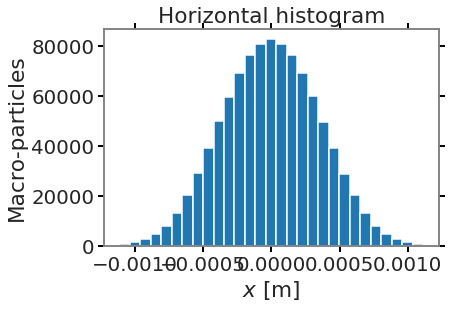

In [117]:
plt.hist(pyht_beam.x, bins=np.linspace(-pyht_beam.sigma_x()*3, pyht_beam.sigma_x()*3, 30));
plt.xlabel('$x$ [m]')
plt.ylabel('Macro-particles')
plt.title('Horizontal histogram')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_horizontalprofile.png', dpi=150, bbox_inches='tight')

# Tune Footprint

In [118]:
import PyNAFF as pnf
sys.path.append(os.path.dirname(os.path.abspath('.')))
from tune_diagram import ResonanceLines

In [119]:
def get_tune(signal_128_turns):
    return pnf.naff(signal_128_turns, 128, 1, 0 , False, window=1)[0,1]

In [120]:
qx_i = np.array([get_tune(i) for i in rec_inc_x[-128:].T])
qy_i = np.array([get_tune(i) for i in rec_inc_y[-128:].T])

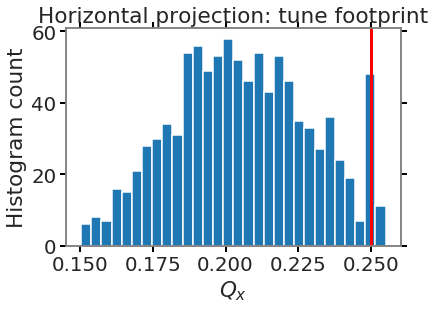

In [121]:
plt.hist(qx_i, bins=30)
plt.axvline(0.25, color='red')
plt.xlabel("$Q_x$")
plt.ylabel('Histogram count')
plt.title('Horizontal projection: tune footprint')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_horizontalspectrum.png', dpi=150, bbox_inches='tight')

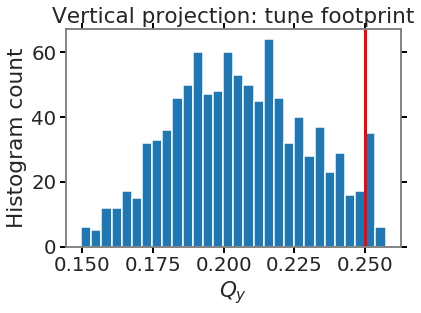

In [122]:
plt.hist(qy_i, bins=30)
plt.axvline(0.25, color='red')
plt.xlabel("$Q_y$")
plt.ylabel('Histogram count')
plt.title('Vertical projection: tune footprint')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_verticalspectrum.png', dpi=150, bbox_inches='tight')

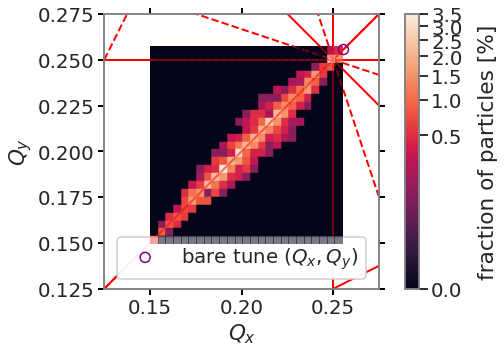

In [123]:
fig = plt.figure(figsize=(8,5)) 

extent_x = (np.floor(Qx) + 0.475 - 0.35, np.ceil(Qx) + 0.025 - 0.25 - 0.5)
extent_y = (np.floor(Qy) + 0.475 - 0.35, np.ceil(Qy) + 0.025 - 0.25 - 0.5)

resonances = ResonanceLines(extent_x, 
                            extent_y,
                            range(1, 4+1), 1)
resonances.plot_resonance(fig)
plt.gca().set_aspect('equal')

inc_tunes_x = np.abs(qx_i)
inc_tunes_y = np.abs(qy_i)

plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25,
           zorder=12, alpha=0.5, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
cbar = plt.colorbar()
cbar.set_label('fraction of particles [%]', labelpad=15)

plt.xlim(extent_x)
plt.ylim(extent_y)

plt.scatter(Qx, Qy, color='purple', marker='o', facecolor='None', 
            linestyle='None', s=100, zorder=13, label=r"bare tune $(Q_x,Q_y)$")
plt.legend(loc=8, framealpha=0.95)

plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)

plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_tunespread.png', dpi=150, bbox_inches='tight')